kaggle 데이터를 사용하여 만든 다중 분류 모델

## 0. Import Library

In [12]:
!pip install tqdm
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for imblearn from https://files.pythonhosted.org/packages/81/a7/4179e6ebfd654bd0eac0b9c06125b8b4c96a9d0a8ff9e9507eb2a26d2d7e/imblearn-0.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/d8/0d/c3bfccc5d460eec8ff56889802aa88f5d07280d5282b307a74558e6edc44/imbalanced_learn-0.12.4-py3-none-any.whl.metadata
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: /Library/Developer/Comm

In [2]:
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
import PIL
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

## 1. Load Data

In [3]:
# 경로 설정
data_dir = "../kaggle/"

# 이미지 리스트 
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

# 카테고리 리스트 및 경로 초기화
path_list = ["Mild Dementia", "Moderate Dementia", 
             "Non Demented", "Very mild Dementia"]

In [4]:
# 카테고리 별 이미지 경로 저장을 위한 딕셔너리 초기화
image_paths = {
    "Mild Dementia": [],
    "Moderate Dementia": [],
    "Non Demented": [],
    "Very mild Dementia": []
}

# 각 카테고리 별 경로 추가
for category in path_list:
    category_dir = os.path.join(data_dir, category)
    for dirname, _, filenames in os.walk(category_dir):
        for filename in filenames:
            image_paths[category].append(os.path.join(dirname, filename))

# 확인
for category in path_list:
    print(f'{category}: {len(image_paths[category])} images')

Mild Dementia: 5002 images
Moderate Dementia: 488 images
Non Demented: 67222 images
Very mild Dementia: 13725 images


In [5]:
# 각 카테고리별 파일 경로 리스트
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

images, labels = [], []

In [6]:
# 각 카테고리 폴더 내 파일 경로를 리스트에 추가
for category in tqdm(path_list):
    category_dir = os.path.join(data_dir, category)
    for root, _, filenames in os.walk(category_dir):
        for filename in filenames:
            image_path = os.path.join(root, filename)
            images.append(image_path)
            labels.append(category)
            if category == "Non Demented":
                non_demented.append(image_path)
            elif category == "Very mild Dementia":
                very_mild_demented.append(image_path)
            elif category == "Mild Dementia":
                mild_demented.append(image_path)
            elif category == "Moderate Dementia":
                moderate_demented.append(image_path)

100%|██████████| 4/4 [00:00<00:00, 26.57it/s]


In [7]:
# 이미지 경로와 레이블을 포함하는 DataFrame 생성
df = pd.DataFrame({'image': images, 'label': labels})
df.head() 

,image,label
0,../kaggle/Mild Dementia/OAS1_0137_MR1_mpr-3_13...,Mild Dementia
1,../kaggle/Mild Dementia/OAS1_0291_MR1_mpr-3_10...,Mild Dementia
2,../kaggle/Mild Dementia/OAS1_0278_MR1_mpr-2_11...,Mild Dementia
3,../kaggle/Mild Dementia/OAS1_0382_MR1_mpr-4_12...,Mild Dementia
4,../kaggle/Mild Dementia/OAS1_0316_MR1_mpr-1_14...,Mild Dementia


/var/folders/s1/nf_zq41n2nd447kv5d44gx2h0000gn/T/ipykernel_55786/1748014159.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df.label,palette='Set1')


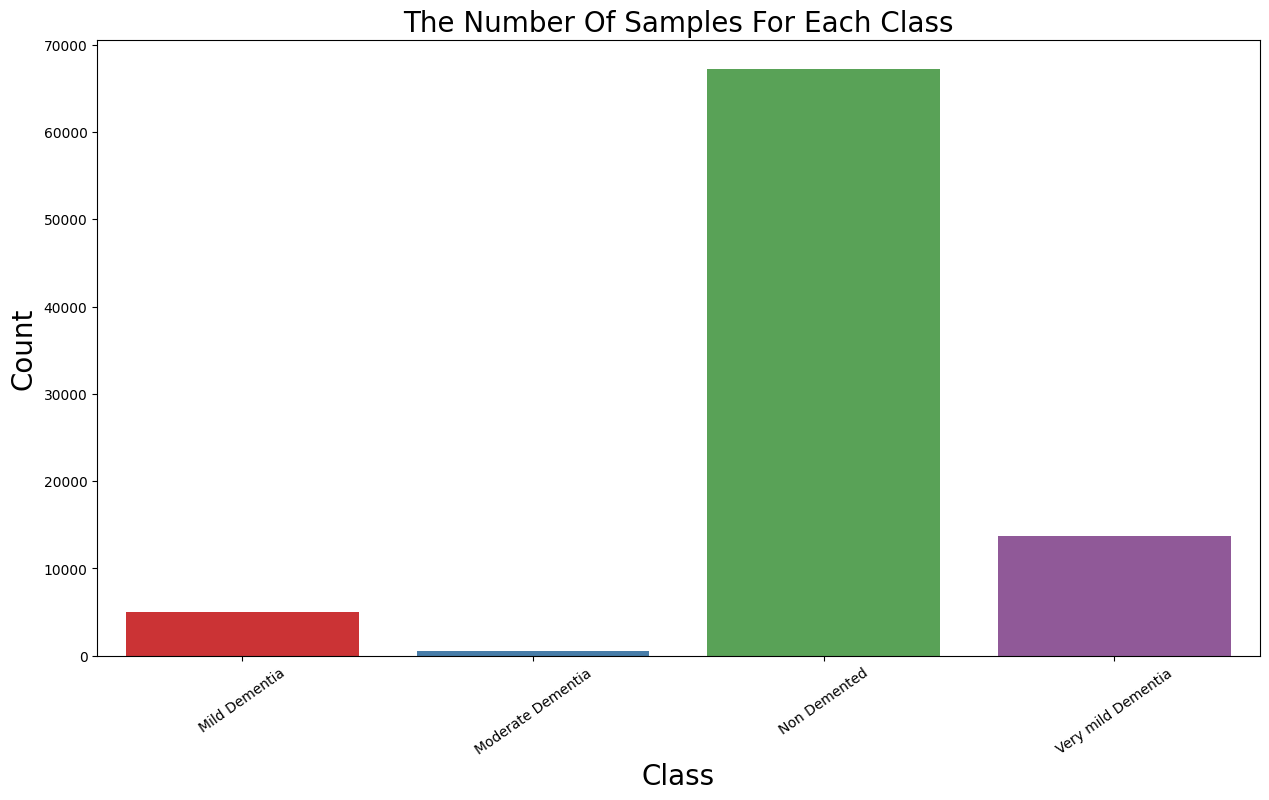

In [8]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(False)
plt.xticks(rotation=35)
plt.show()

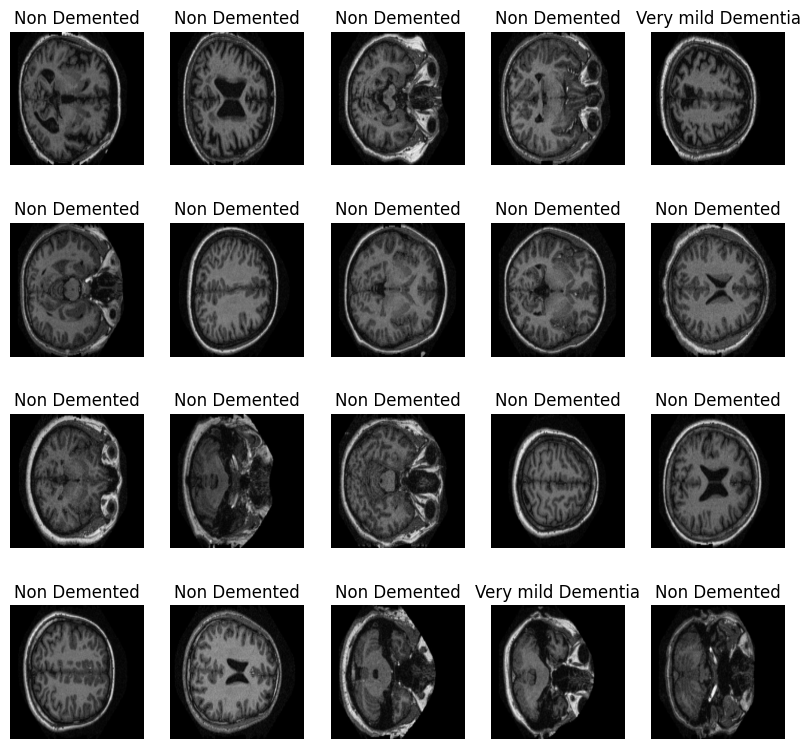

In [9]:
plt.figure(figsize=(10,12))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(5,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=12)

## 2. Preprocessing

In [10]:
data = []
result = []

### 1) Label Encoding

In [11]:
encoder= OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [12]:
# 각 리스트에서 이미지를 읽어와 데이터와 결과에 추가하는 함수
def load_images(category_list, label):
    for image_path in category_list:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((128, 128))
        img = np.array(img)
        data.append(img)
        result.append(encoder.transform([[label]]).toarray())

In [13]:
# 각 카테고리별로 이미지 로드
load_images(non_demented, 0)
load_images(very_mild_demented, 1)
load_images(mild_demented, 2)
load_images(moderate_demented, 3)

In [14]:
# 결과 데이터 변환 확인
data = np.array(data)
result = np.array(result).reshape(len(result), -1)
print(f"Data shape: {data.shape}, Result shape: {result.shape}")

Data shape: (86437, 128, 128, 3), Result shape: (86437, 4)


### 2) Reshape data

In [15]:
X=np.array(data)
y=np.array(result)
y=y.reshape(X.shape[0],4)
y=np.argmax(y, axis=1)

### 3) Split data

In [16]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2,random_state=42, shuffle = True)
X_train.shape
X_test.shape

(17288, 128, 128, 3)

## 3. Modeling

In [17]:
# CNN 모델 생성
def create_compile_model():
    model=Sequential()
    model.add(Conv2D(filters=32,kernel_size=2,padding='Same',input_shape = (128,128,3)))

    model.add(Conv2D(filters=32,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
    model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
    model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4,activation='softmax'))

    print(model.summary())

    model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

In [18]:
# EalryStopping 설정
early_stopping=EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)


## 4. Training

In [19]:
model = create_compile_model()

/Users/chaewon/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,518,596 (32.50 MB)

 Trainable params: 8,518,148 (32.49 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [22]:
history= model.fit(X_train,
                   y_train,
                   validation_split=0.2,
                   epochs=15,
                   callbacks=[early_stopping],
                    batch_size=32)

Epoch 1/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 612s 354ms/step - accuracy: 0.8668 - loss: 0.3247 - val_accuracy: 0.9422 - val_loss: 0.1500
Epoch 2/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 4078s 2s/step - accuracy: 0.9343 - loss: 0.1598 - val_accuracy: 0.9839 - val_loss: 0.0692
Epoch 3/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 967s 560ms/step - accuracy: 0.9599 - loss: 0.1107 - val_accuracy: 0.9850 - val_loss: 0.0521
Epoch 4/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 1247s 721ms/step - accuracy: 0.9700 - loss: 0.0816 - val_accuracy: 0.9907 - val_loss: 0.0290
Epoch 5/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 1197s 692ms/step - accuracy: 0.9747 - loss: 0.0667 - val_accuracy: 0.9986 - val_loss: 0.0075
Epoch 6/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 572s 331ms/step - accuracy: 0.9789 - loss: 0.0581 - val_accuracy: 0.9987 - val_loss: 0.0082
Epoch 7/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 573s 331ms/step - accuracy: 0.9815 - loss: 0.0519 - val_accuracy: 0.9991 - val_loss: 0.0050
Epoch 8/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 573s 331ms/step - ac

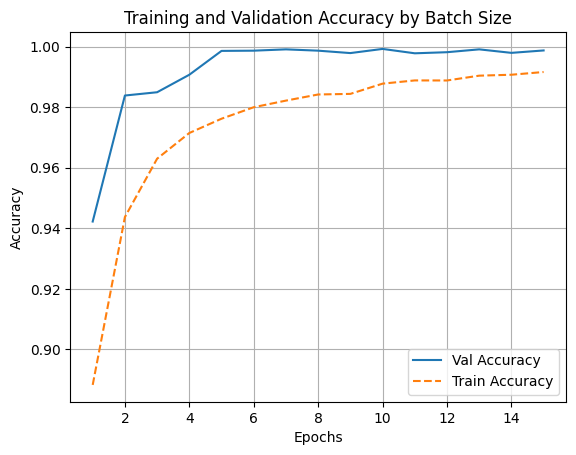

In [ ]:
val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['accuracy']
epochs = range(1, len(val_accuracy) + 1)

plt.plot(epochs, val_accuracy,  label=f'Val Accuracy')
plt.plot(epochs, train_accuracy, linestyle='--', label=f'Train Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()